## 3.1 Contents<a id='3.1_Contents'></a>

  * [3.2 Load The Data](#3.2_Load_The_Data)      
  * [3.3 Aggregate_by_year](#3.3_Aggregate_by_year)
  * [3.4 Split the data into train and test](#3.4_Split_the_data_into_train_and_test)
  * [3.5 Baseline Modeling](#3.5_Baseline_Modeling)
  * [3.6 Box Cox Transformation](#3.6_Box_Cox_Transformation)
  * [3.7 Linear Regression Model](#3.7_Linear_Regression_Model)
  * [3.8 AutoARIMA Model](#3.8_AutoARIMA_Model)
  * [3.9 Augmented Dickey-Fuller Test (ADF).](#3.9_Augmented_Dickey-Fuller_Test_(ADF))
  * [3.10 SARIMA Model](#3.10_SARIMA_Model)
  * [3.11 Facebook Prophet Model](#3.11_Facebook_Prophet_Model)
  * [3.12 Overall Evaluation](#3.12_Overall_Evaluation)
  * [3.13 Summary](#3.13_Summary)


[<a href="#3.1_Contents">Back to top</a>] 

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Tuple

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sklearn.linear_model import LinearRegression
from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.fbprophet import Prophet

### 3.2  Load The Data<a id='3.2_Load_The_Data'></a>     

In [2]:
df=pd.read_csv('./Data/311_calls_reduced_size.csv') #upload data

C:\Users\asiya\AppData\Local\Temp\ipykernel_20064\1104846100.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('./Data/311_calls_reduced_size.csv') #upload data


In [3]:
df.head()

,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Borough,Police Precincts,Call count
0,2022-12-31,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,10033.0,MANHATTAN,22.0,1
1,2022-12-31,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,11226.0,BROOKLYN,43.0,1
2,2022-12-31,DOHMH,Department of Health and Mental Hygiene,Rodent,Signs of Rodents,10035.0,MANHATTAN,16.0,1
3,2022-12-31,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,11385.0,QUEENS,62.0,1
4,2022-12-31,NYPD,New York City Police Department,Abandoned Vehicle,With License Plate,11385.0,QUEENS,62.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11965861 entries, 0 to 11965860
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Created Date      object 
 1   Agency            object 
 2   Agency Name       object 
 3   Complaint Type    object 
 4   Descriptor        object 
 5   Incident Zip      object 
 6   Borough           object 
 7   Police Precincts  float64
 8   Call count        int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 821.6+ MB


##### Organize the data with respect to months for applying the baseline modeling

In [5]:
df['Created Date'] = pd.to_datetime(df['Created Date'])
df.set_index('Created Date', inplace=True)

# Rename the column to 'date'
df.rename(columns={'Created Date': 'Date'}, inplace=True)

# Resample the data to get monthly sums
df = df['Call count'].resample('M').sum()

# Create a new DataFrame with just 2 columns
df = pd.DataFrame({'Date': df.index, 'Call count': df.values})

# Display the resulting DataFrame
df.head()

,Date,Call count
0,2019-01-31,241718
1,2019-02-28,203242
2,2019-03-31,223620
3,2019-04-30,223892
4,2019-05-31,247341


In [6]:
df.set_index('Date', inplace=True) 

In [7]:
df.head()

,Call count
Date,
2019-01-31,241718
2019-02-28,203242
2019-03-31,223620
2019-04-30,223892
2019-05-31,247341


### Monthly call count

In [8]:
def basic_plot(df: pd.DataFrame, name ) -> Tuple[mpl.figure.Figure, mpl.axes.Axes]:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(f"{name} Call Count")
    ax.plot(df)

    ax.set_xlabel('Date')  
    ax.set_ylabel('Call count')

    return fig, ax
    


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Monthly Call Count'}, xlabel='Date', ylabel='Call count'>)

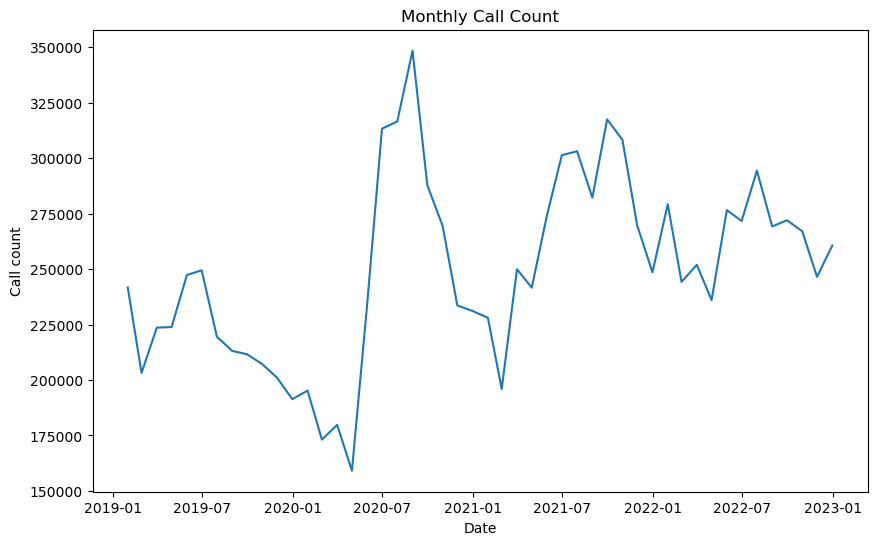

In [9]:
basic_plot(df, "Monthly")

[<a href="#3.1_Contents">Back to top</a>] 

### 3.3 Aggregate_by_year<a id='3.3_Aggregate_by_year'></a>  

In [10]:
by_year = df.groupby(by=df.index.year).sum()    
  
by_year.index = by_year.index.rename('Year')

In [11]:
by_year.head()

,Call count
Year,
2019,2633126
2020,2942058
2021,3220901
2022,3169776


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Yealy Call Count'}, xlabel='Date', ylabel='Call count'>)

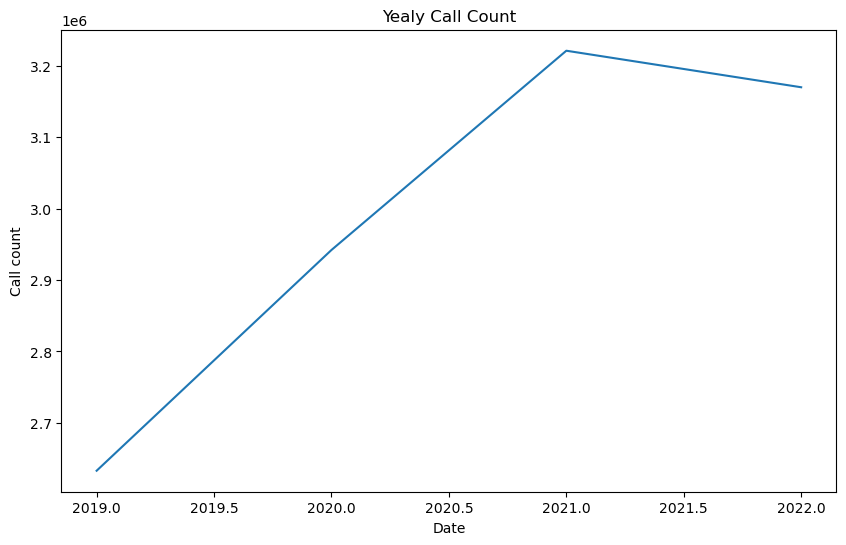

In [12]:
basic_plot(by_year, "Yealy")

### 3.4 Split the data into train and test <a id='3.4_Split_the_data_into_train_and_test'></a>  

In [13]:
def train_test_split(df: pd.DataFrame, test_len: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
  
    test = df.iloc[-test_len:]   

    train = df.iloc[:-test_len]

    return train, test

train, test = train_test_split(df, test_len=18)

display(train.tail(3), test.head(3))

,Call count
Date,
2021-04-30,241648
2021-05-31,274411
2021-06-30,301378


,Call count
Date,
2021-07-31,303152
2021-08-31,282244
2021-09-30,317507


<br/>

## <div style="padding:10px;background-color:#9d5a47;margin:10;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 1px 10px;overflow:hidden;font-weight:50;width:auto">Baseline Modeling</div>

### 3.5 Baseline Modeling <a id='3.5_Baseline_Modeling'></a>  

In [14]:

def plot_preds(train, test, pred, model_name):
    """Utility Function to plot the predictions"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.autofmt_xdate()
    
    # Custom y-axis tick locations and labels
    y_ticks_range = range(240000, 320001, 20000)
    y_ticks_labels = [f"{y // 1000}K" for y in y_ticks_range]

    # plot the training data, testing data, and predictions
    ax1.set_title(f"{model_name} predicted Calls")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Calls")
    ax1.set_yticks(y_ticks_range)
    ax1.set_yticklabels(y_ticks_labels, fontsize=8)  # Adjust the fontsize here
    ax1.plot(train["Call count"], label="Training Data")
    ax1.plot(test["Call count"], label="Test Data")
    ax1.plot(pred, label=f"{model_name} Predictions", ls='--')
    ax1.legend(fontsize='small')

    # plot as above, but only for the forecast horizon
    ax2.set_title(f"{model_name} predicted Calls (FH only)")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Calls")
    ax2.set_yticks(y_ticks_range)
    ax2.set_yticklabels(y_ticks_labels, fontsize=8)  # Adjust the fontsize here
    ax2.plot(test["Call count"], label="Test Data", color='C1')
    ax2.plot(pred, label=model_name, color='C2', ls='--')
    ax2.legend()

plt.show()

### 3.6 Box Cox Transformation<a id='3.6_Box_Cox_Transformation'></a>  

In [15]:
results = []
fh = np.arange(1, len(test) + 1)
train, test = train_test_split(df, test_len=18)

boxcox = BoxCoxTransformer()
train_bc = boxcox.fit_transform(train)

[<a href="#3.1_Contents">Back to top</a>] 

### 3.7 Linear Regression Model<a id='3.7_Linear_Regression_Model'></a>  

In [16]:
# this trend forecaster will be our baseline. It's base model is a simple linear regression

baseline = TrendForecaster(LinearRegression())
baseline.fit(train_bc)

TrendForecaster(regressor=LinearRegression())

,Call count
2021-07-31,256857.999089
2021-08-31,258822.195107
2021-09-30,260745.081088


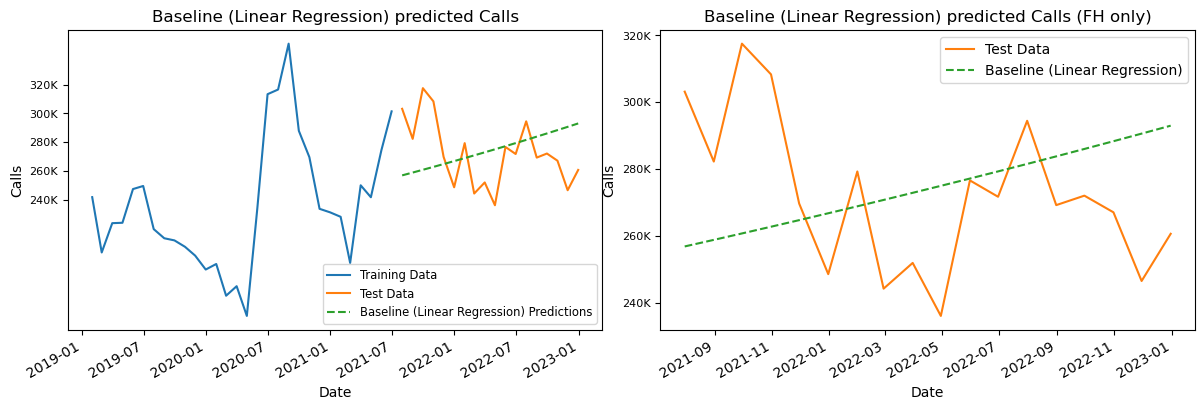

In [17]:
baseline_pred = baseline.predict(fh=fh, X=train_bc['Call count'])
baseline_pred = boxcox.inverse_transform(baseline_pred)
display(baseline_pred.head(3))
plot_preds(train, test, baseline_pred, "Baseline (Linear Regression)")

In [18]:
rmse = mean_squared_error(test["Call count"], baseline_pred) ** 0.5
mape = mean_absolute_percentage_error(test["Call count"], baseline_pred)
results.append(['Linear Regression', rmse, mape])

print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

RMSE: 29042.705
MAPE: 0.089


### 3.8 AutoARIMA Model<a id='3.8_AutoARIMA_Model'></a>  

In [19]:
from sktime.forecasting.arima import AutoARIMA

auto_arima = AutoARIMA(
    seasonal=True,
    sp=11,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
)
auto_arima.fit(train["Call count"])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[11] intercept   : AIC=710.630, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[11] intercept   : AIC=730.831, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[11] intercept   : AIC=711.222, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[11] intercept   : AIC=721.289, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[11]             : AIC=830.353, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[11] intercept   : AIC=708.758, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[11] intercept   : AIC=707.915, Time=0.10 sec
 ARIMA(2,0,2)(1,0,0)[11] intercept   : AIC=708.762, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[11] intercept   : AIC=707.292, Time=0.05 sec
 ARIMA(1,0,2)(1,0,0)[11] intercept   : AIC=709.082, Time=0.08 sec
 ARIMA(1,0,2)(0,0,1)[11] intercept   : AIC=708.794, Time=0.08 sec
 ARIMA(1,0,2)(1,0,1)[11] intercept   : AIC=710.477, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[11] intercept   : AIC=715.811, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[11] intercept   : AIC=710.548, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[11] intercep

AutoARIMA(error_action='ignore', sp=11, suppress_warnings=True, trace=True)

In [20]:
# show a summary of the basic fitted parameters for ARIMA
fitted_params = auto_arima.get_fitted_params()
print(f"Order:          {fitted_params['order']}")
print(f"Seasonal Order: {fitted_params['seasonal_order']}")

Order:          (1, 0, 2)
Seasonal Order: (0, 0, 0, 11)


[<a href="#3.1_Contents">Back to top</a>] 

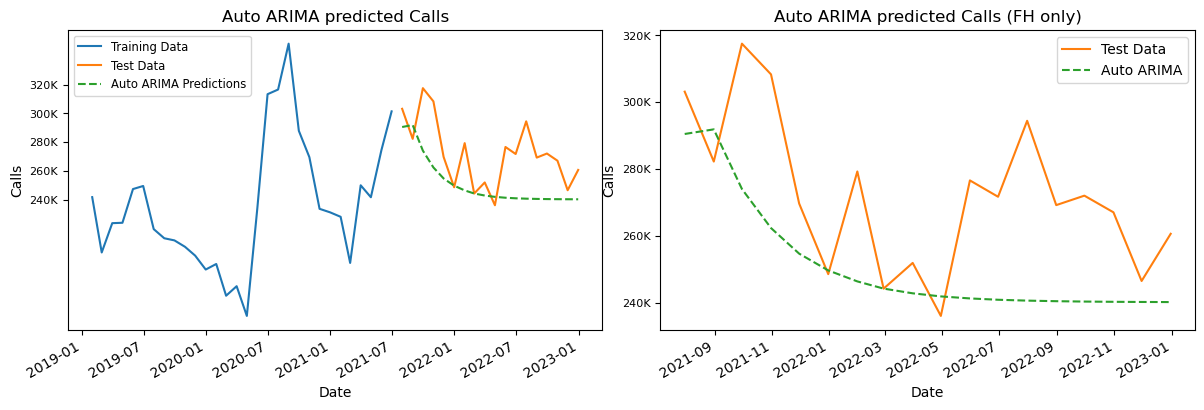

In [21]:
aa_pred = auto_arima.predict(fh=fh)

# we have to inverse the original transformation
#aa_pred = boxcox.inverse_transform(aa_pred)
aa_pred.head(3)
plot_preds(train, test, aa_pred, "Auto ARIMA")

In [22]:
aa_pred.head()

2021-07-31    290493.941111
2021-08-31    291873.635023
2021-09-30    274039.779649
2021-10-31    262356.160058
2021-11-30    254701.787861
Freq: M, Name: Call count, dtype: float64

In [23]:
rmse = mean_squared_error(test["Call count"], aa_pred) ** 0.5
mape = mean_absolute_percentage_error(test["Call count"], aa_pred)
results.append(['Auto ARIMA', rmse, mape])

print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

RMSE: 27654.942
MAPE: 0.081


In [24]:
aa_pred.head()

2021-07-31    290493.941111
2021-08-31    291873.635023
2021-09-30    274039.779649
2021-10-31    262356.160058
2021-11-30    254701.787861
Freq: M, Name: Call count, dtype: float64

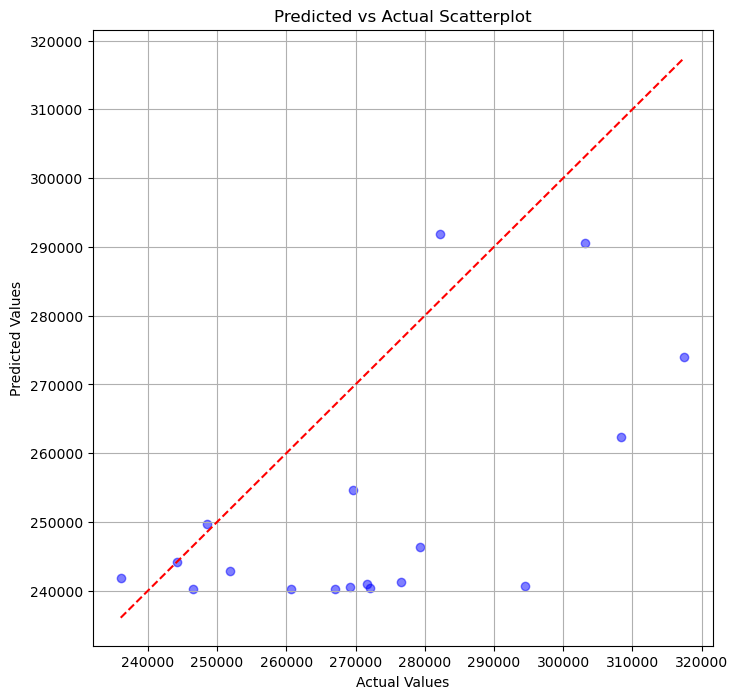

In [25]:
# Extract actual values from the test dataframe
actual_values = test["Call count"]

# scatterplot with the reference 45-degree line
plt.figure(figsize=(8, 8))
plt.scatter(actual_values, aa_pred, color='blue', alpha=0.5)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Scatterplot")
plt.grid()
plt.show()

<Axes: ylabel='Density'>

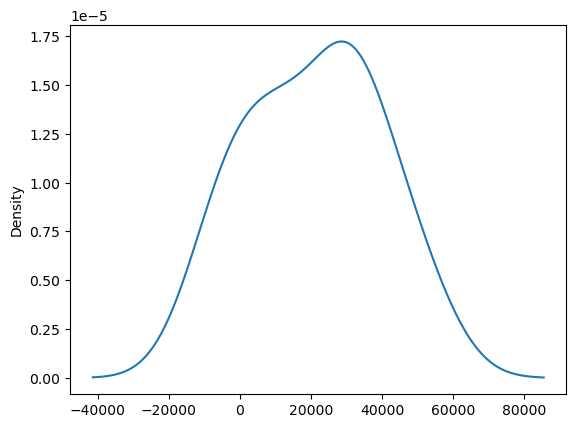

In [26]:
residuals = actual_values - aa_pred
residuals.plot(kind='kde')

In [27]:
# Calculate the mean of the actual values
mean_actual = np.mean(actual_values)

# Calculate the total sum of squares (TSS)
tss = np.sum((actual_values - mean_actual) ** 2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((actual_values - aa_pred) ** 2)

# Calculate R-squared
r_squared = 1 -np.abs(tss / rss)

# Calculate the number of independent variables (predictors)
# In time series forecasting, this could be 1 if you're using only the past values as predictors
num_predictors = 1

# Calculate the number of observations
num_observations = len(actual_values)

# Calculate Adjusted R-squared
adjusted_r_squared = 1 - ((tss / (num_observations - num_predictors - 1)) / (rss / (num_observations - 1)))

print(f"R-Squared: {r_squared:.4f}")
print(f"Adjusted R-Squared: {adjusted_r_squared:.4f}")

R-Squared: 0.3557
Adjusted R-Squared: 0.3154


[<a href="#3.1_Contents">Back to top</a>] 

### 3.9 Augmented Dickey-Fuller Test (ADF).<a id='3.9_Augmented_Dickey-Fuller_Test_(ADF)'></a>  

In [28]:
from statsmodels.tsa.stattools import adfuller

In [29]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is STATIONARY")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [30]:
adf_test(df['Call count'])

ADF Statistics: -3.170395324078135
p- value: 0.02176354916484808
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is STATIONARY


In [31]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

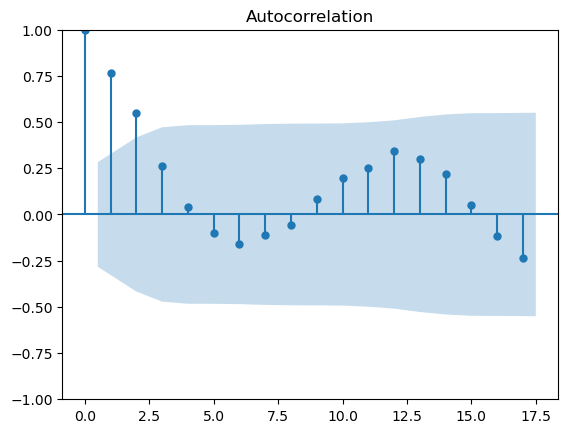

In [32]:
acf = plot_acf(df["Call count"].dropna())

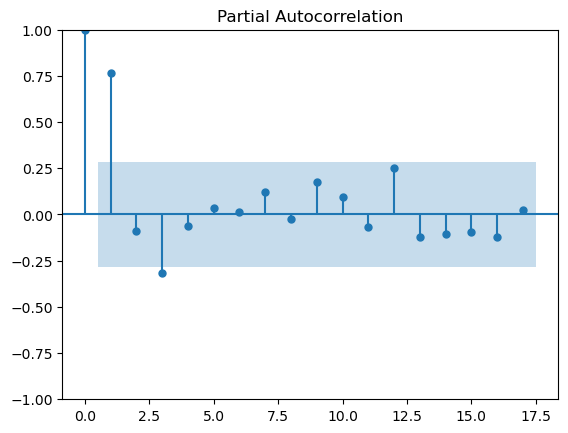

In [33]:
pacf = plot_pacf(df["Call count"].dropna())

### 3.10 SARIMA Model<a id='3.10_SARIMA_ Model'></a>  

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [35]:
model_SARIMA=SARIMAX(train["Call count"] ,order=(2,0,1),seasonal_order=(0,0,0,11))

C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [36]:
model_SARIMA_fit=model_SARIMA.fit()


C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[<a href="#3.1_Contents">Back to top</a>] 

In [37]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Call count   No. Observations:                   30
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -354.627
Date:                Tue, 15 Aug 2023   AIC                            717.253
Time:                        00:03:38   BIC                            722.858
Sample:                    01-31-2019   HQIC                           719.046
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1942      0.166      1.172      0.241      -0.131       0.519
ar.L2          0.7911      0.167      4.740      0.000       0.464       1.118
ma.L1          0.9810      0.306      3.202      0.001       0.381       1.581
sigma2      9.704e+08   4.84e-10   2.01e+18      0.000     9.7e+08     9.7e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.69   Prob(JB):                         0.36
Heteroskedasticity (H):               2.44   Skew:                             0.60
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+34. Standard errors may be unstable.
"""

In [38]:
##prediction
pred_start_date=test.index[0]
pred_end_date=test.index[-1]
print(pred_start_date)
print(pred_end_date)

2021-07-31 00:00:00
2022-12-31 00:00:00


In [39]:
from datetime import datetime,timedelta
pred_Sarima=model_SARIMA_fit.predict(start=datetime(2021,7,31),end=datetime(2022,12,31))
residuals=test['Call count']-pred_Sarima

<Axes: xlabel='Date'>

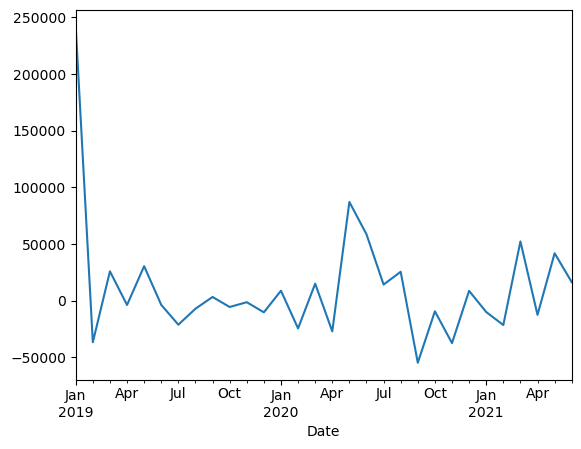

In [40]:
model_SARIMA_fit.resid.plot()

<Axes: ylabel='Density'>

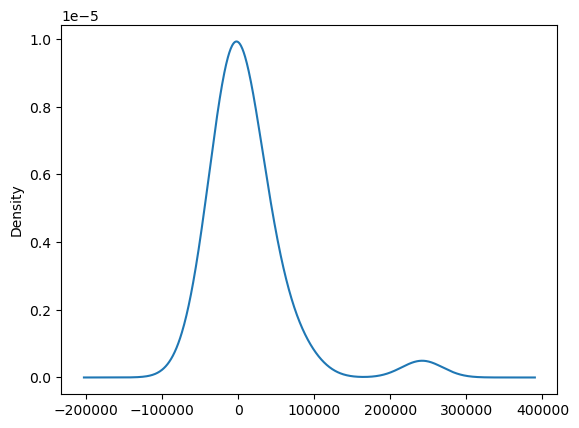

In [41]:
model_SARIMA_fit.resid.plot(kind='kde')

In [42]:

test['Predicted_SARIMA']=pred_Sarima

C:\Users\asiya\AppData\Local\Temp\ipykernel_20064\2946139561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_SARIMA']=pred_Sarima


Text(0.5, 1.0, 'SARIMA predicted Calls')

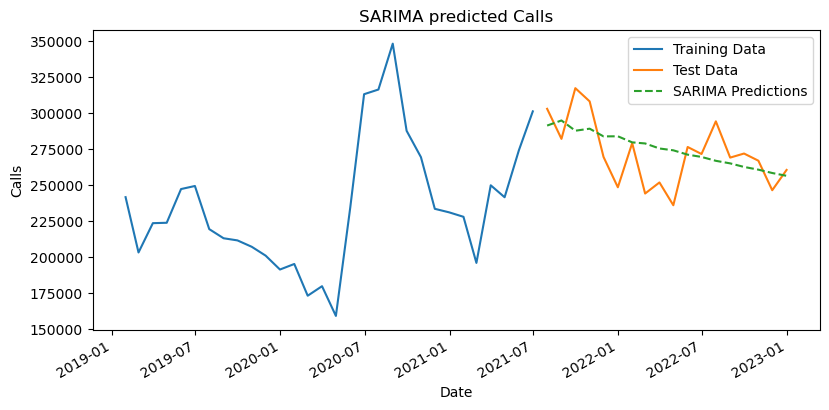

In [43]:
fig, ax1 = plt.subplots(figsize=(8, 4))
fig.tight_layout()
fig.autofmt_xdate()

# plot the training data, testing data, and predictions
ax1.set_xlabel("Date")
ax1.set_ylabel("Calls")
ax1.plot(train["Call count"], label="Training Data")
ax1.plot(test["Call count"], label="Test Data")
ax1.plot(test['Predicted_SARIMA'], label="SARIMA Predictions", ls='--')
ax1.legend()
ax1.set_title("SARIMA predicted Calls")

[<a href="#3.1_Contents">Back to top</a>] 

In [44]:
rmse = mean_squared_error(test["Call count"], test['Predicted_SARIMA']) ** 0.5
mape = mean_absolute_percentage_error(test["Call count"], test['Predicted_SARIMA'])
results.append(['SARIMA', rmse, mape])

print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

RMSE: 20161.449
MAPE: 0.061


In [45]:
from sktime.forecasting.fbprophet import Prophet

### 3.11 Facebook Prophet Model<a id='3.11_Facebook_Prophet_Model'></a>  

In [46]:
prophet = Prophet(
            seasonality_mode="multiplicative",
           
        )
prophet.fit(train_bc["Call count"])

Importing plotly failed. Interactive plots will not work.
00:03:39 - cmdstanpy - INFO - Chain [1] start processing
00:03:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet(seasonality_mode='multiplicative')

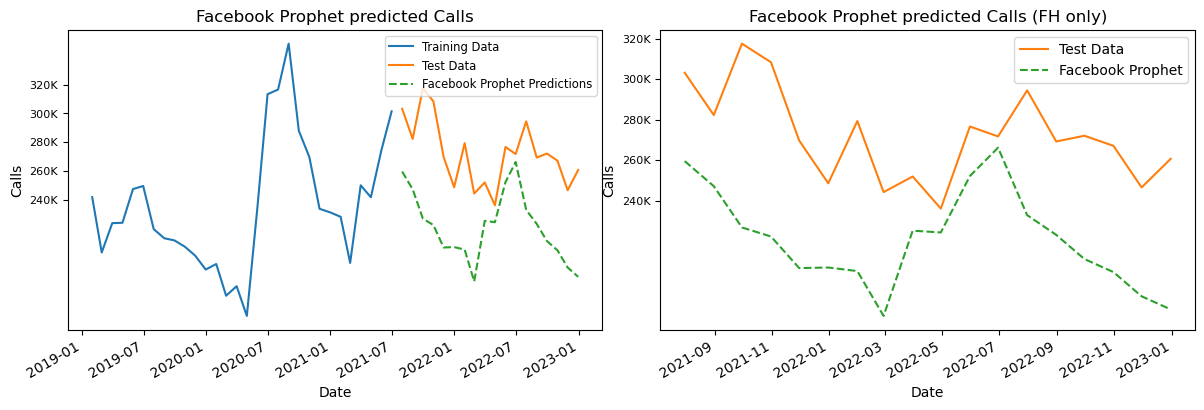

In [47]:
prophet_pred = prophet.predict(fh=fh)

# we have to inverse the original transformation
prophet_pred = boxcox.inverse_transform(prophet_pred)
prophet_pred.head(3)
plot_preds(train, test, prophet_pred, "Facebook Prophet")

In [48]:
rmse = mean_squared_error(test["Call count"], prophet_pred) ** 0.5
mape = mean_absolute_percentage_error(test["Call count"], prophet_pred)
results.append(['Prophet', rmse, mape])
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

RMSE: 56315.614
MAPE: 0.186


### 3.12 Overall Evaluation<a id='3.12_Overall_Evaluation'></a>  

In [49]:
results_df = (
    pd.DataFrame(columns=["model", "RMSE", "MAPE"], data=results)
    .set_index("model")
    .sort_values("RMSE")
)

results_df

,RMSE,MAPE
model,,
SARIMA,20161.448571,0.060617
Auto ARIMA,27654.942052,0.080626
Linear Regression,29042.705155,0.089417
Prophet,56315.613985,0.186385


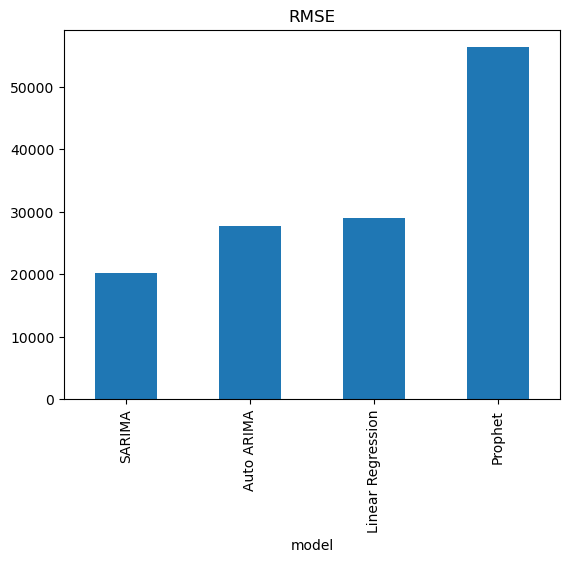

In [50]:
(results_df['RMSE']
    .sort_values(ascending=True)
    .plot(kind='bar', title='RMSE'));

### 3.13 Summary:<a id='3.13_Summary'></a>  

I started with a Linear Regression model after applying the Box-Cox Transformer to stabilize the variance and make the dataset more closely resemble a normal distribution. After that, I used the AutoARIMA model, SARIMA, and Prophet and then evaluated the performance of these models.
Among the evaluated models, the SARIMA model demonstrates superior predictive performance with the lowest RMSE of 20161.45 and the lowest MAPE of 0.061, indicating its effectiveness in capturing the underlying patterns in the data. The Auto ARIMA model follows with slightly higher RMSE and MAPE values at 27,654.94 and 0.0806, respectively. On the other hand, the Linear Regression model presents less accurate predictions with an RMSE of 29,042.71 and a MAPE of 0.0894. The Prophet model shows the highest prediction errors, reflected by the highest RMSE of 56,315.61 and a MAPE of 0.1864. Overall, the SARIMA model emerges as the most suitable choice for this dataset in terms of accurate forecasting.

[<a href="#3.1_Contents">Back to top</a>] 